In [0]:
"""
Created on Tue Nov  5 14:01:57 2019

@author: Sakayo_Toadoum
"""

import numpy as np                       
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import tree
plt.style.use('seaborn-notebook')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [4]:
ls

 BirthData2.xlsx                         LSTM_model.py          tsplot.png
'Copie de Bienvenue dans Colaboratory'   Sari_NN_byRock.ipynb   Untitled0.ipynb
 distplot.png                            Time_serie2.ipynb      Untitled1.ipynb
 LSTM_model.ipynb                        ts.csv                 Untitled2.ipynb


In [5]:
ts=pd.read_csv("ts.csv", delimiter=',')
from datetime import datetime
con=ts['Draw.up.date']
ts['Draw.up.date']=pd.to_datetime(ts['Draw.up.date'])
ts.set_index('Draw.up.date', inplace=True)
#check datatype of index
ts.index

DatetimeIndex(['2010-01-02', '2010-01-11', '2010-01-18', '2010-01-21',
               '2010-01-26', '2010-02-09', '2010-02-18', '2010-02-19',
               '2010-02-22', '2010-03-05',
               ...
               '2019-07-05', '2019-07-15', '2019-07-23', '2019-07-26',
               '2019-08-04', '2019-08-05', '2019-10-05', '2019-11-04',
               '2019-12-03', '2019-12-06'],
              dtype='datetime64[ns]', name='Draw.up.date', length=457, freq=None)

In [6]:
# weekly baseline
ts['baseline'] = ts.daily_count.shift(1)

# moving averages
ts['MVA2'] = ts.daily_count.rolling(2).mean().shift(1)
ts['MVA4'] = ts.daily_count.rolling(4).mean().shift(1)
ts['MVA6'] = ts.daily_count.rolling(6).mean().shift(1)
ts['MVA8'] = ts.daily_count.rolling(8).mean().shift(1)
ts.head(9)


,daily_count,baseline,MVA2,MVA4,MVA6,MVA8
Draw.up.date,,,,,,
2010-01-02,1,NaN,NaN,NaN,NaN,NaN
2010-01-11,1,1.0,NaN,NaN,NaN,NaN
2010-01-18,1,1.0,1.0,NaN,NaN,NaN
2010-01-21,2,1.0,1.0,NaN,NaN,NaN
2010-01-26,7,2.0,1.5,1.25,NaN,NaN
2010-02-09,4,7.0,4.5,2.75,NaN,NaN
2010-02-18,1,4.0,5.5,3.50,2.666667,NaN
2010-02-19,1,1.0,2.5,3.50,2.666667,NaN
2010-02-22,2,1.0,1.0,3.25,2.666667,2.25


In [7]:
ts.drop(ts.index[:8], inplace=True)
ts.head(8)

,daily_count,baseline,MVA2,MVA4,MVA6,MVA8
Draw.up.date,,,,,,
2010-02-22,2,1.0,1.0,3.25,2.666667,2.250
2010-03-05,3,2.0,1.5,2.00,2.833333,2.375
2010-03-11,7,3.0,2.5,1.75,3.000000,2.625
2010-03-16,1,7.0,5.0,3.25,3.000000,3.375
2010-03-19,1,1.0,4.0,3.25,2.500000,3.250
2010-03-22,1,1.0,1.0,3.00,2.500000,2.500
2010-03-26,2,1.0,1.0,2.50,2.500000,2.125
2010-03-29,1,2.0,1.5,1.25,2.500000,2.250


Text(0, 0.5, 'frequency')

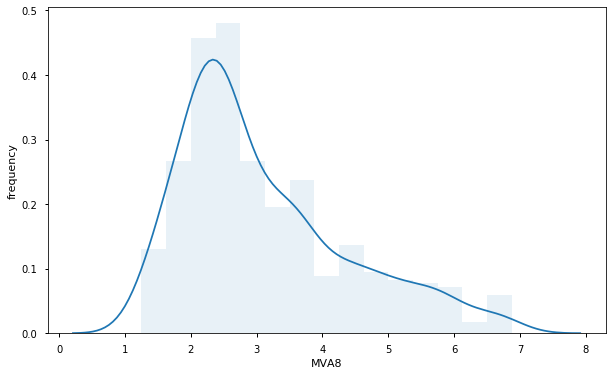

In [8]:
#distribution plot
plt.figure(figsize=(10, 6))
sns.distplot(ts.MVA8, hist_kws={'alpha': 0.1}, kde = True, kde_kws={'alpha': 1})
plt.ylabel('frequency')

In [0]:
#Define the training set
training_set = ts['MVA8'].values

training_set = training_set.reshape(-1,1)
#feature scaling
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(training_set[0:380])
test_set_scaled= sc.fit_transform(training_set[332:449])


In [0]:
#Creating a data structure with 48 timesteps and 1 output
#train
X_train=[]
Y_train=[]
for i in range(48, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-48:i,0])
    Y_train.append(training_set_scaled[i,0])
X_train, Y_train=np.array(X_train), np.array(Y_train)

#test
X_test=[]
Y_test=[]
for i in range(48, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-48:i,0])
    Y_test.append(test_set_scaled[i,0])
    
X_test,Y_test=np.array(X_test),np.array(Y_test)

#Reshaping
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))


In [11]:
#Building the RNN
from sklearn import datasets
from sklearn.metrics import mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#initialising the RNN
regressor= Sequential()

#adding the first LSTM layer and some dropout regularization
regressor.add(LSTM(units=50, return_sequences = True , input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

#adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences = True ))
regressor.add(Dropout(0.2))

#adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50 ))
regressor.add(Dropout(0.2))

#adding the output layer
regressor.add(Dense(units=1))

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
#Compiling the RNN
regressor.compile(optimizer= 'adam', loss= 'mean_squared_error')

#Fitting the RNN to the training set
history=regressor.fit(X_train, Y_train, epochs=100, batch_size=32)
history.history



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





332/332 [==============================] - 4s 13ms/step - loss: 0.0603
Epoch 2/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0353
Epoch 3/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0345
Epoch 4/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0340
Epoch 5/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0319
Epoch 6/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0322
Epoch 7/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0297
Epoch 8/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0279
Epoch 9/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0290
Epoch 10/100
332/332 [==============================] - 1s 4ms/step - loss: 0.0290
Epoch 11/100
332/332 [==============================] - 1s 4ms/step - loss:

{'loss': [0.0602883050240666,
  0.03528920951557447,
  0.034508577177682555,
  0.03395461986761495,
  0.03194698446755668,
  0.03222170022192849,
  0.029748718736760587,
  0.027904109199004,
  0.02897621044911534,
  0.028979185733001633,
  0.026289352563669884,
  0.024966079135795672,
  0.023640983098422188,
  0.021336752135890077,
  0.02000126256663577,
  0.01920628358037716,
  0.018402576390429432,
  0.01599612857877131,
  0.015082251583506545,
  0.014728521771100631,
  0.01541551796113511,
  0.014341383454311326,
  0.015787889058870005,
  0.014671973569924572,
  0.012299818435616523,
  0.011532268273722694,
  0.013441208570477474,
  0.012458212987845203,
  0.011689355669834887,
  0.011444278459726688,
  0.011607374098286572,
  0.012792457231735608,
  0.011745043760951025,
  0.011959918258509722,
  0.011403154873524803,
  0.010959924933646458,
  0.010873191159622497,
  0.011089528473206314,
  0.010557833941182098,
  0.010114262214334434,
  0.010802803173975414,
  0.01117830839097859,

In [0]:
#prediction
X_test=np.array(X_test)
X_test_shape=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_birth=regressor.predict(X_test_shape)
predicted_birth=sc.inverse_transform(predicted_birth)
Y_test=sc.inverse_transform(np.array(Y_test).reshape(-1,1))


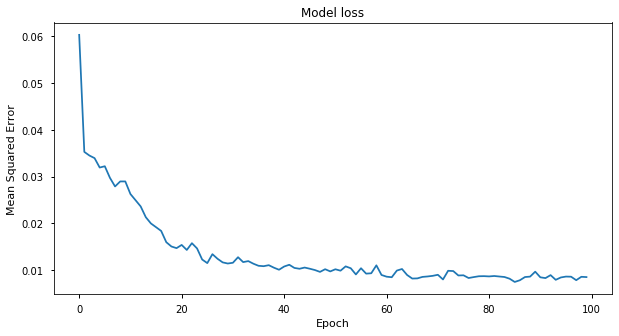

In [14]:
#epochs plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
#plt.savefig('lstm2plot.png')
plt.show()


MAE on the data: 0.4800
RMSE on the data: 0.6140
MAPE on the data: 12.1800


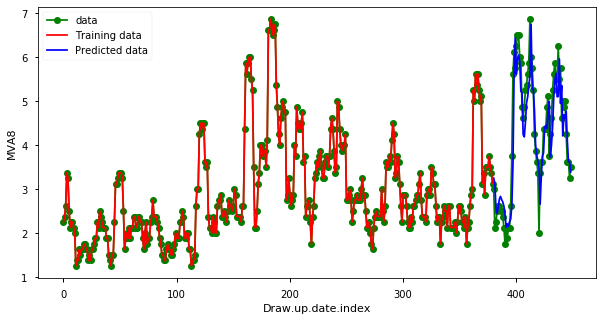

In [15]:
#vizualising result
errors = abs(predicted_birth - Y_test)
MAE=round(np.mean(errors), 2)
rmse =np.sqrt(mean_squared_error(Y_test,predicted_birth))
mape = 100 * (errors / Y_test)
MAPE=round(np.mean(mape), 2)
print('MAE on the data: %.4f' %MAE)
print('RMSE on the data: %.4f' %rmse)
print('MAPE on the data: %.4f' %MAPE)
plt.figure(figsize=(10, 5))
plt.plot(training_set,'o-',color='green',label='data')
plt.plot(range(0,380),training_set[0:380], color='red', label='Training data')
plt.plot(range(380,449) ,predicted_birth, color='blue', label='Predicted data')
plt.xlabel('Draw.up.date.index')
plt.ylabel('MVA8')
plt.legend()
#plt.savefig('lstm3plot.png')
plt.show()

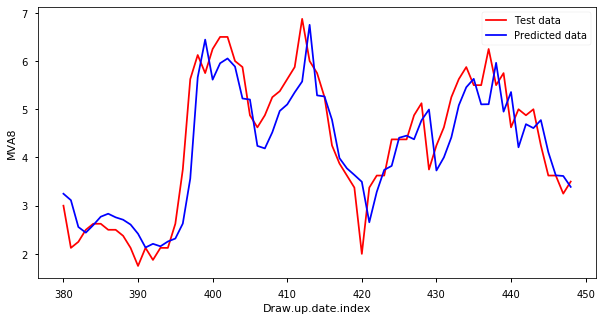

In [16]:
#plot of test and predict
plt.figure(figsize=(10, 5))
plt.plot(range(380,449),Y_test, color='red', label='Test data')
plt.plot(range(380,449) ,predicted_birth, color='blue', label='Predicted data')
plt.xlabel('Draw.up.date.index')
plt.ylabel('MVA8')
plt.legend()
plt.savefig('lstm4plot.png')
plt.show()
